# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

Client dataset columns:

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0


Invoice data

- Client_id: Unique id for the client
- Invoice_date: Date of the invoice
- Tarif_type: Type of tax
- Counter_number: the meter's ID
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: consuption band 1
- Consommation_level_2: consuption band 2
- Consommation_level_3: consuption band 3
- Consommation_level_4: consuption band 4
- Old_index: Old index
- New_index: New index
- Months_number: time since last reading, in months
- Counter_type: Type of counter, whether is electricity (ELEC) meter or gas (GAZ) meter, later we shall encode it as `{ELEC : 0, GAZ : 1}`

# Libraries set up

In [1]:
#libraries for data handling and EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#libraries for modelling
from sklearn.preprocessing import StandardScaler
from sklearn.impute import (
    SimpleImputer, 
    KNNImputer)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PolynomialFeatures,
    KBinsDiscretizer
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


#hide warnings
import warnings
warnings.simplefilter('ignore')

RSEED = 42

# Modelling

In [5]:
#load the prepared data
client = pd.read_csv('data/client_formatted.csv')
invoice = pd.read_csv('data/invoice_formatted.csv')
fraud_df = pd.read_csv('data/fraud_occurences.csv')
normal_df = pd.read_csv('data/normal_occurences.csv')
invoice_client_merge_df = pd.read_csv('data/invoice_client_merge.csv')

## Feature engineering

In [142]:
feats_stats = ['meter_state', 'reading_remark', 'months_since_last_reading', 'consum_band_1', 'old_index', 'new_index']
invoice_client_elec_stats = invoice_client_merge_df[invoice_client_merge_df['meter_type'] == 0].groupby(['client_id', 
                                                                                                   'client_catg',  
                                                                                                   'fraud'], as_index = False)[feats_stats].mean()
invoice_client_elec_stats.rename(columns = {'meter_state' : 'mean_meter_state', 
                                            'reading_remark' : 'mean_reading_remark', 
                                            'months_since_last_reading' : 'mean_months_since_last_reading', 
                                            'consum_band_1' : 'mean_consum_band_1', 
                                            'old_index' : 'mean_old_index', 
                                            'new_index' : 'mean_new_index'}, inplace = True)
invoice_client_elec_stats.head()

,client_id,client_catg,fraud,mean_meter_state,mean_reading_remark,mean_months_since_last_reading,mean_consum_band_1,mean_old_index,mean_new_index
0,train_Client_0,11,0,0.0,6.971429,4.628571,352.400000,9444.542857,9807.514286
1,train_Client_1,11,0,0.0,7.216216,4.324324,557.540541,14330.756757,14888.297297
2,train_Client_10,11,0,0.0,7.055556,6.444444,798.611111,32873.000000,33709.500000
3,train_Client_100,11,0,0.0,6.150000,4.200000,1.200000,94.150000,95.350000
4,train_Client_1000,11,0,0.0,8.857143,3.714286,663.714286,6900.428571,7823.071429


In [143]:
invoice_client_elec_stats = pd.concat([invoice_client_elec_stats, 
                                       invoice_client_merge_df[invoice_client_merge_df['meter_type'] == 0].groupby(['client_id', 
                                                                                                   'client_catg',  
                                                                                                   'fraud'], as_index = False)[feats_stats].var()], axis = 1)
invoice_client_elec_stats = invoice_client_elec_stats.loc[:,~invoice_client_elec_stats.columns.duplicated()]
invoice_client_elec_stats.rename(columns = {'meter_state' : 'var_meter_state', 
                                            'reading_remark' : 'var_reading_remark', 
                                            'months_since_last_reading' : 'var_months_since_last_reading', 
                                            'consum_band_1' : 'var_consum_band_1', 
                                            'old_index' : 'var_old_index', 
                                            'new_index' : 'var_new_index'}, inplace = True)
invoice_client_elec_stats.head()

,client_id,client_catg,fraud,mean_meter_state,mean_reading_remark,mean_months_since_last_reading,mean_consum_band_1,mean_old_index,mean_new_index,var_meter_state,var_reading_remark,var_months_since_last_reading,var_consum_band_1,var_old_index,var_new_index
0,train_Client_0,11,0,0.0,6.971429,4.628571,352.400000,9444.542857,9807.514286,0.0,1.557983,4.416807,96313.070588,2.050047e+07,2.097335e+07
1,train_Client_1,11,0,0.0,7.216216,4.324324,557.540541,14330.756757,14888.297297,0.0,1.896396,1.891892,39178.644144,3.750492e+07,3.745102e+07
2,train_Client_10,11,0,0.0,7.055556,6.444444,798.611111,32873.000000,33709.500000,0.0,1.584967,11.555556,264032.957516,2.827241e+07,3.072740e+07
3,train_Client_100,11,0,0.0,6.150000,4.200000,1.200000,94.150000,95.350000,0.0,0.450000,0.378947,13.010526,1.697632e+01,3.529211e+01
4,train_Client_1000,11,0,0.0,8.857143,3.714286,663.714286,6900.428571,7823.071429,0.0,0.131868,0.527473,50549.142857,2.239288e+07,2.069039e+07


In [144]:
invoice_client_elec_stats = pd.concat([invoice_client_elec_stats, 
                                       invoice_client_merge_df[invoice_client_merge_df['meter_type'] == 0].groupby(['client_id', 
                                                                                                   'client_catg',  
                                                                                                   'fraud'], as_index = False)[feats_stats].std()], axis = 1)
invoice_client_elec_stats = invoice_client_elec_stats.loc[:,~invoice_client_elec_stats.columns.duplicated()]
invoice_client_elec_stats.rename(columns = {'meter_state' : 'std_meter_state', 
                                            'reading_remark' : 'std_reading_remark', 
                                            'months_since_last_reading' : 'std_months_since_last_reading', 
                                            'consum_band_1' : 'std_consum_band_1', 
                                            'old_index' : 'std_old_index', 
                                            'new_index' : 'std_new_index'}, inplace = True)
invoice_client_elec_stats.head()

,client_id,client_catg,fraud,mean_meter_state,mean_reading_remark,mean_months_since_last_reading,mean_consum_band_1,mean_old_index,mean_new_index,var_meter_state,...,var_months_since_last_reading,var_consum_band_1,var_old_index,var_new_index,std_meter_state,std_reading_remark,std_months_since_last_reading,std_consum_band_1,std_old_index,std_new_index
0,train_Client_0,11,0,0.0,6.971429,4.628571,352.400000,9444.542857,9807.514286,0.0,...,4.416807,96313.070588,2.050047e+07,2.097335e+07,0.0,1.248192,2.101620,310.343472,4527.744415,4579.666655
1,train_Client_1,11,0,0.0,7.216216,4.324324,557.540541,14330.756757,14888.297297,0.0,...,1.891892,39178.644144,3.750492e+07,3.745102e+07,0.0,1.377097,1.375461,197.935960,6124.126094,6119.723768
2,train_Client_10,11,0,0.0,7.055556,6.444444,798.611111,32873.000000,33709.500000,0.0,...,11.555556,264032.957516,2.827241e+07,3.072740e+07,0.0,1.258955,3.399346,513.841374,5317.180865,5543.230331
3,train_Client_100,11,0,0.0,6.150000,4.200000,1.200000,94.150000,95.350000,0.0,...,0.378947,13.010526,1.697632e+01,3.529211e+01,0.0,0.670820,0.615587,3.607011,4.120232,5.940716
4,train_Client_1000,11,0,0.0,8.857143,3.714286,663.714286,6900.428571,7823.071429,0.0,...,0.527473,50549.142857,2.239288e+07,2.069039e+07,0.0,0.363137,0.726273,224.831365,4732.111217,4548.668807


In [145]:
invoice_client_elec_stats = pd.concat([invoice_client_elec_stats, 
                                       invoice_client_merge_df[invoice_client_merge_df['meter_type'] == 0].groupby(['client_id', 
                                                                                                   'client_catg',  
                                                                                                   'fraud'], as_index = False)[feats_stats].median()], axis = 1)
invoice_client_elec_stats = invoice_client_elec_stats.loc[:,~invoice_client_elec_stats.columns.duplicated()]
invoice_client_elec_stats.rename(columns = {'meter_state' : 'median_meter_state', 
                                            'reading_remark' : 'median_reading_remark', 
                                            'months_since_last_reading' : 'median_months_since_last_reading', 
                                            'consum_band_1' : 'median_consum_band_1', 
                                            'old_index' : 'median_old_index', 
                                            'new_index' : 'median_new_index'}, inplace = True)
invoice_client_elec_stats.head()

,client_id,client_catg,fraud,mean_meter_state,mean_reading_remark,mean_months_since_last_reading,mean_consum_band_1,mean_old_index,mean_new_index,var_meter_state,...,std_months_since_last_reading,std_consum_band_1,std_old_index,std_new_index,median_meter_state,median_reading_remark,median_months_since_last_reading,median_consum_band_1,median_old_index,median_new_index
0,train_Client_0,11,0,0.0,6.971429,4.628571,352.400000,9444.542857,9807.514286,0.0,...,2.101620,310.343472,4527.744415,4579.666655,0.0,6.0,4.0,267.0,7770.0,9156.0
1,train_Client_1,11,0,0.0,7.216216,4.324324,557.540541,14330.756757,14888.297297,0.0,...,1.375461,197.935960,6124.126094,6119.723768,0.0,6.0,4.0,520.0,14232.0,14680.0
2,train_Client_10,11,0,0.0,7.055556,6.444444,798.611111,32873.000000,33709.500000,0.0,...,3.399346,513.841374,5317.180865,5543.230331,0.0,6.0,4.0,655.5,31469.0,32158.5
3,train_Client_100,11,0,0.0,6.150000,4.200000,1.200000,94.150000,95.350000,0.0,...,0.615587,3.607011,4.120232,5.940716,0.0,6.0,4.0,0.0,91.0,94.5
4,train_Client_1000,11,0,0.0,8.857143,3.714286,663.714286,6900.428571,7823.071429,0.0,...,0.726273,224.831365,4732.111217,4548.668807,0.0,9.0,4.0,770.0,6989.5,7829.5


In [146]:
invoice_client_elec_stats = pd.concat([invoice_client_elec_stats, 
                                       invoice_client_merge_df[invoice_client_merge_df['meter_type'] == 0].groupby(['client_id', 
                                                                                                   'client_catg',  
                                                                                                   'fraud'], as_index = False)[feats_stats].min()], axis = 1)
invoice_client_elec_stats = invoice_client_elec_stats.loc[:,~invoice_client_elec_stats.columns.duplicated()]
invoice_client_elec_stats.rename(columns = {'meter_state' : 'min_meter_state', 
                                            'reading_remark' : 'min_reading_remark', 
                                            'months_since_last_reading' : 'min_months_since_last_reading', 
                                            'consum_band_1' : 'min_consum_band_1', 
                                            'old_index' : 'min_old_index', 
                                            'new_index' : 'min_new_index'}, inplace = True)
invoice_client_elec_stats.head()

,client_id,client_catg,fraud,mean_meter_state,mean_reading_remark,mean_months_since_last_reading,mean_consum_band_1,mean_old_index,mean_new_index,var_meter_state,...,median_months_since_last_reading,median_consum_band_1,median_old_index,median_new_index,min_meter_state,min_reading_remark,min_months_since_last_reading,min_consum_band_1,min_old_index,min_new_index
0,train_Client_0,11,0,0.0,6.971429,4.628571,352.400000,9444.542857,9807.514286,0.0,...,4.0,267.0,7770.0,9156.0,0,6,2,38,3685,3809
1,train_Client_1,11,0,0.0,7.216216,4.324324,557.540541,14330.756757,14888.297297,0.0,...,4.0,520.0,14232.0,14680.0,0,6,2,190,4110,4661
2,train_Client_10,11,0,0.0,7.055556,6.444444,798.611111,32873.000000,33709.500000,0.0,...,4.0,655.5,31469.0,32158.5,0,6,4,188,25515,25974
3,train_Client_100,11,0,0.0,6.150000,4.200000,1.200000,94.150000,95.350000,0.0,...,4.0,0.0,91.0,94.5,0,6,4,0,90,90
4,train_Client_1000,11,0,0.0,8.857143,3.714286,663.714286,6900.428571,7823.071429,0.0,...,4.0,770.0,6989.5,7829.5,0,8,2,124,0,959


In [147]:
invoice_client_elec_stats = pd.concat([invoice_client_elec_stats, 
                                       invoice_client_merge_df[invoice_client_merge_df['meter_type'] == 0].groupby(['client_id', 
                                                                                                   'client_catg',  
                                                                                                   'fraud'], as_index = False)[feats_stats].max()], axis = 1)
invoice_client_elec_stats = invoice_client_elec_stats.loc[:,~invoice_client_elec_stats.columns.duplicated()]
invoice_client_elec_stats.rename(columns = {'meter_state' : 'max_meter_state', 
                                            'reading_remark' : 'max_reading_remark', 
                                            'months_since_last_reading' : 'max_months_since_last_reading', 
                                            'consum_band_1' : 'max_consum_band_1', 
                                            'old_index' : 'max_old_index', 
                                            'new_index' : 'max_new_index'}, inplace = True)
invoice_client_elec_stats.head()

,client_id,client_catg,fraud,mean_meter_state,mean_reading_remark,mean_months_since_last_reading,mean_consum_band_1,mean_old_index,mean_new_index,var_meter_state,...,min_months_since_last_reading,min_consum_band_1,min_old_index,min_new_index,max_meter_state,max_reading_remark,max_months_since_last_reading,max_consum_band_1,max_old_index,max_new_index
0,train_Client_0,11,0,0.0,6.971429,4.628571,352.400000,9444.542857,9807.514286,0.0,...,2,38,3685,3809,0,9,12,1200,16493,17078
1,train_Client_1,11,0,0.0,7.216216,4.324324,557.540541,14330.756757,14888.297297,0.0,...,2,190,4110,4661,0,9,8,1207,23940,25022
2,train_Client_10,11,0,0.0,7.055556,6.444444,798.611111,32873.000000,33709.500000,0.0,...,4,188,25515,25974,0,9,12,2400,41532,44614
3,train_Client_100,11,0,0.0,6.150000,4.200000,1.200000,94.150000,95.350000,0.0,...,4,0,90,90,0,9,6,15,99,114
4,train_Client_1000,11,0,0.0,8.857143,3.714286,663.714286,6900.428571,7823.071429,0.0,...,2,124,0,959,0,9,4,800,13337,13729


In [148]:
invoice_client_elec_stats.to_csv('data/invoice_client_elec_stats.csv', index = False)

## Base-line model

**Raw data**

In [325]:
cols = invoice_client_merge_df.columns.tolist()
target = cols.pop(-3)
remove_cols = ['client_id', 'invoice_month', 'invoice_year', 'creation_month', 'creation_year']
for elem in remove_cols:
    cols.remove(elem)
feats = cols

In [326]:
X = invoice_client_merge_df[feats]
y = invoice_client_merge_df[target]

In [327]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = RSEED, stratify=y)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    824719
           1       0.79      0.78      0.78     70622

    accuracy                           0.97    895341
   macro avg       0.88      0.88      0.88    895341
weighted avg       0.97      0.97      0.97    895341



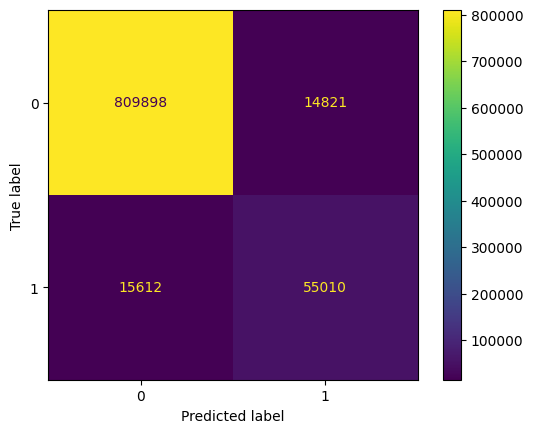

In [330]:
fraud_detect_dec_tree = DecisionTreeClassifier(max_depth=50, random_state = RSEED)
fraud_detect_dec_tree.fit(X_train,y_train)
y_pred = fraud_detect_dec_tree.predict(X_test)
print(classification_report(y_test,y_pred))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

In [329]:
imp_feats_raw = pd.DataFrame(data = {'features': feats, 
                     'importances': (fraud_detect_dec_tree.feature_importances_*100).round(2)}).sort_values(by = 'importances', 
                                                                                                            ascending = False).reset_index(drop = True)
imp_feats_raw

,features,importances
0,meter_id,67.02
1,new_index,7.07
2,old_index,6.59
3,consum_band_1,5.47
4,region,4.18
5,meter_code,2.33
6,consum_band_2,1.52
7,months_since_last_reading,1.16
8,reading_remark,1.12
9,client_catg,0.92


**Raw data, less features**

In [295]:
feats = [elem for elem in imp_feats_raw[imp_feats_raw['importances'] > 1.]['features']]
target = 'fraud'

In [296]:
X = invoice_client_merge_df[feats]
y = invoice_client_merge_df[target]

In [297]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = RSEED, stratify=y)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    824719
           1       0.77      0.75      0.76     70622

    accuracy                           0.96    895341
   macro avg       0.87      0.87      0.87    895341
weighted avg       0.96      0.96      0.96    895341



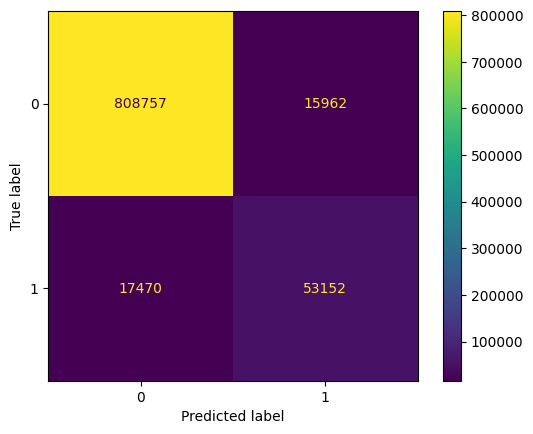

In [298]:
fraud_detect_dec_tree = DecisionTreeClassifier(max_depth=50)
fraud_detect_dec_tree.fit(X_train,y_train)
y_pred = fraud_detect_dec_tree.predict(X_test)
print(classification_report(y_test,y_pred))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

**Statistics**

In [264]:
cols = invoice_client_elec_stats.columns.tolist()
target = cols.pop(2)
cols.remove('client_id')
feats = cols

In [265]:
X = invoice_client_elec_stats[feats]
y = invoice_client_elec_stats[target]

In [266]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = RSEED, stratify=y)

In [277]:
cols_to_fill = ['var_meter_state', 'var_reading_remark', 'var_months_since_last_reading',
                'var_consum_band_1', 'var_old_index', 'var_new_index',
               'std_meter_state', 'std_reading_remark', 'std_months_since_last_reading',
                'std_consum_band_1', 'std_old_index', 'std_new_index']
for col in cols_to_fill:
    X_train[col].fillna(value = X_train[col].mean(), inplace = True)
    X_test[col].fillna(value = X_test[col].mean(), inplace = True)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     25451
           1       0.14      0.16      0.15      1512

    accuracy                           0.90     26963
   macro avg       0.54      0.55      0.55     26963
weighted avg       0.90      0.90      0.90     26963



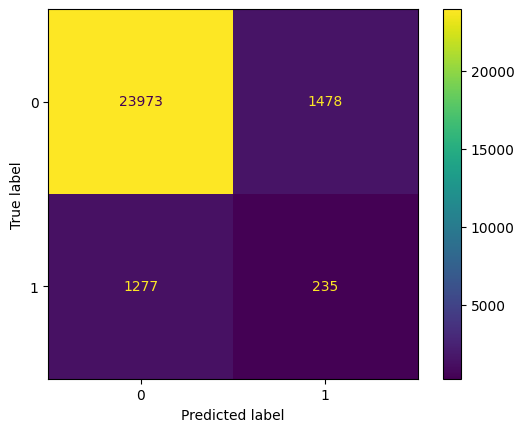

In [282]:
fraud_detect_dec_tree = DecisionTreeClassifier(max_depth=50)
fraud_detect_dec_tree.fit(X_train,y_train)
y_pred = fraud_detect_dec_tree.predict(X_test)
print(classification_report(y_test,y_pred))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

In [283]:
pd.DataFrame(data = {'features': feats, 
                     'importances': (fraud_detect_dec_tree.feature_importances_*100).round(2)}).sort_values(by = 'importances', 
                                                                                                            ascending = False).reset_index(drop = True)

,features,importances
0,mean_consum_band_1,9.23
1,mean_reading_remark,7.12
2,median_consum_band_1,6.21
3,mean_new_index,5.94
4,median_old_index,5.80
5,std_old_index,5.76
6,mean_months_since_last_reading,5.66
7,mean_old_index,5.54
8,median_new_index,5.42
9,std_consum_band_1,4.65


## Models

**Raw data**

In [166]:
cols = invoice_client_merge_df.columns.tolist()
target = cols.pop(-3)
remove_cols = ['client_id', 'invoice_month', 'invoice_year', 'creation_month', 'creation_year']
for elem in remove_cols:
    cols.remove(elem)
feats = cols

In [167]:
X = invoice_client_merge_df[feats].copy()
y = invoice_client_merge_df[target].copy()

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = RSEED, stratify=y)

In [158]:
num_feats = ['consum_band_1', 'consum_band_2', 'consum_band_3', 'consum_band_4', 'new_index', 'old_index']
cat_feats = [elem for elem in feats if elem not in num_cols]

In [159]:
my_minmax = MinMaxScaler()
X_train[num_feats] = my_minmax.fit_transform(X_train[num_feats])
X_test[num_feats] = my_minmax.fit_transform(X_test[num_feats])

In [160]:
X_train[cat_feats] = X_train[cat_feats].astype('category')
X_test[cat_feats] = X_test[cat_feats].astype('category')

In [161]:
y_train.value_counts()

fraud
0    3298871
1     282490
Name: count, dtype: int64

In [162]:
from imblearn.over_sampling import RandomOverSampler 

ros = RandomOverSampler(random_state=RSEED, sampling_strategy='minority')
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [169]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=RSEED)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    824719
           1       0.79      0.55      0.65     70622

    accuracy                           0.95    895341
   macro avg       0.88      0.77      0.81    895341
weighted avg       0.95      0.95      0.95    895341



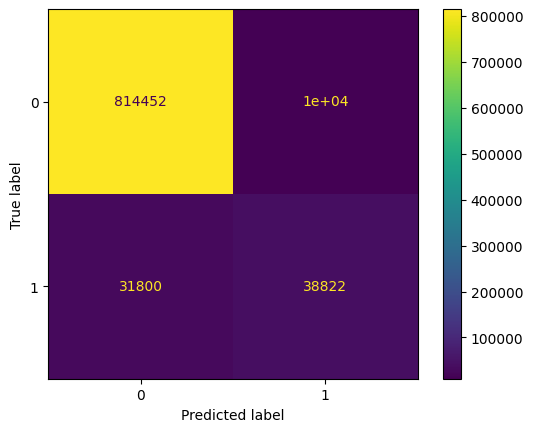

In [163]:
fraud_detect_forest = RandomForestClassifier(n_estimators = 10, max_depth=50, random_state=RSEED, max_features = None, n_jobs = -1)
fraud_detect_forest.fit(X_train_resampled,y_train_resampled)
y_pred = fraud_detect_forest.predict(X_test)
print(classification_report(y_test,y_pred))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    824719
           1       0.79      0.78      0.78     70622

    accuracy                           0.97    895341
   macro avg       0.88      0.88      0.88    895341
weighted avg       0.97      0.97      0.97    895341



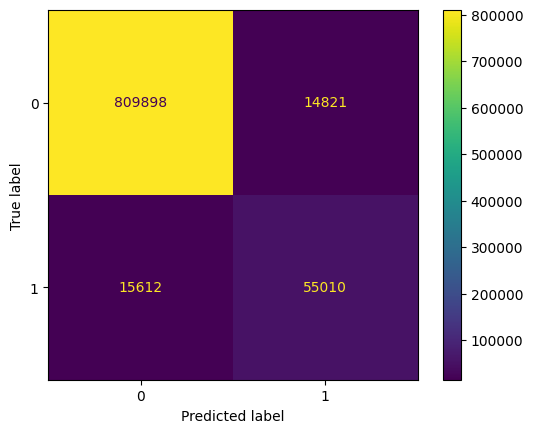

In [170]:
fraud_detect_dec_tree = DecisionTreeClassifier(max_depth=50, random_state = RSEED)
fraud_detect_dec_tree.fit(X_train,y_train)
y_pred = fraud_detect_dec_tree.predict(X_test)
print(classification_report(y_test,y_pred))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

**Statistics**

In [149]:
cols = invoice_client_elec_stats.columns.tolist()
target = cols.pop(2)
cols.remove('client_id')
feats = cols

In [150]:
X = invoice_client_elec_stats[feats]
y = invoice_client_elec_stats[target]

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = RSEED, stratify=y)

In [152]:
cols_to_fill = ['var_meter_state', 'var_reading_remark', 'var_months_since_last_reading',
                'var_consum_band_1', 'var_old_index', 'var_new_index',
               'std_meter_state', 'std_reading_remark', 'std_months_since_last_reading',
                'std_consum_band_1', 'std_old_index', 'std_new_index']
for col in cols_to_fill:
    X_train[col].fillna(value = X_train[col].mean(), inplace = True)
    X_test[col].fillna(value = X_test[col].mean(), inplace = True)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     25451
           1       0.50      0.07      0.13      1512

    accuracy                           0.94     26963
   macro avg       0.72      0.53      0.55     26963
weighted avg       0.92      0.94      0.92     26963



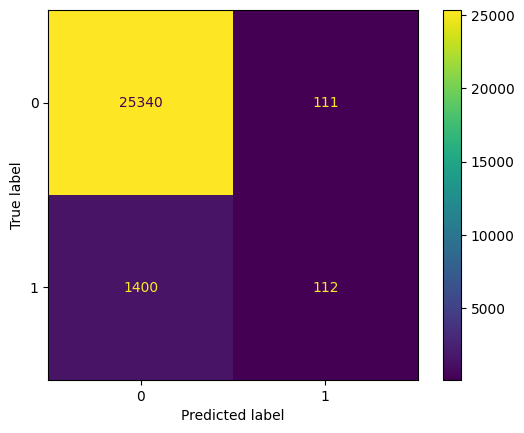

In [153]:
fraud_detect_forest = RandomForestClassifier(n_estimators = 10, max_depth=50, random_state=RSEED, n_jobs = -1)
fraud_detect_forest.fit(X_train,y_train)
y_pred = fraud_detect_forest.predict(X_test)
print(classification_report(y_test,y_pred))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

**grid search**

In [6]:
cols = invoice_client_merge_df.columns.tolist()
target = cols.pop(-3)
remove_cols = ['client_id', 'invoice_month', 'invoice_year', 'creation_month', 'creation_year']
for elem in remove_cols:
    cols.remove(elem)
feats = cols

In [7]:
X = invoice_client_merge_df[feats].copy()
y = invoice_client_merge_df[target].copy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = RSEED, stratify=y)

In [9]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [10]:
# Defining parameter grid (as dictionary)
param_grid = {'max_depth' : [10, 50, 100, 200],
              'min_samples_split' : [10, 50, 100],
              'class_weight' : ['None', 'balanced']
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(DecisionTreeClassifier(random_state = RSEED), param_grid, scoring='precision',
                  cv=2, verbose=5, n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


GridSearchCV(cv=2, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['None', 'balanced'],
                         'max_depth': [10, 50, 100, 200],
                         'min_samples_split': [10, 50, 100]},
             scoring='precision', verbose=5)

In [11]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: 0.524
Best parameters: {'class_weight': 'balanced', 'max_depth': 100, 'min_samples_split': 10}


              precision    recall  f1-score   support

           0       0.99      0.97      0.98    824719
           1       0.69      0.83      0.75     70622

    accuracy                           0.96    895341
   macro avg       0.84      0.90      0.86    895341
weighted avg       0.96      0.96      0.96    895341



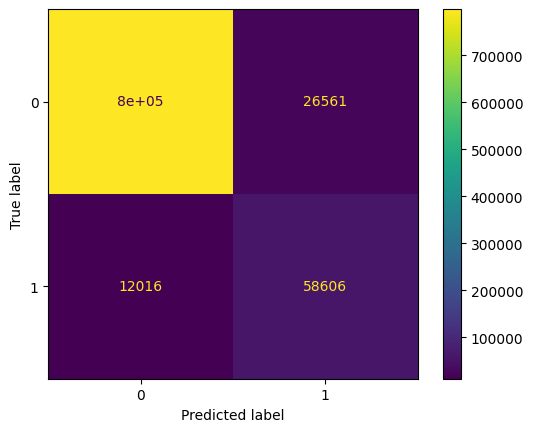

In [13]:
dc_best = gs.best_estimator_
y_pred = dc_best.predict(X_test)
print(classification_report(y_test,y_pred))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

## Train LGBM *Classifier*

In [ ]:
x_train = train.drop(columns=['target'])
y_train = train['target']

In [ ]:
model = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)
model.fit(x_train, y_train)

In [ ]:
x_train.disrict.unique()

## Make Predictions on test set

In [ ]:
test.columns

In [ ]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

In [ ]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

In [ ]:
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

## Tips 
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************